In [1]:
# OFICIAL: https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
data = pd.read_csv("./data/daily_minimum_temperatures.csv", sep=",")
print(data.shape)
data.head()

(3650, 2)


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


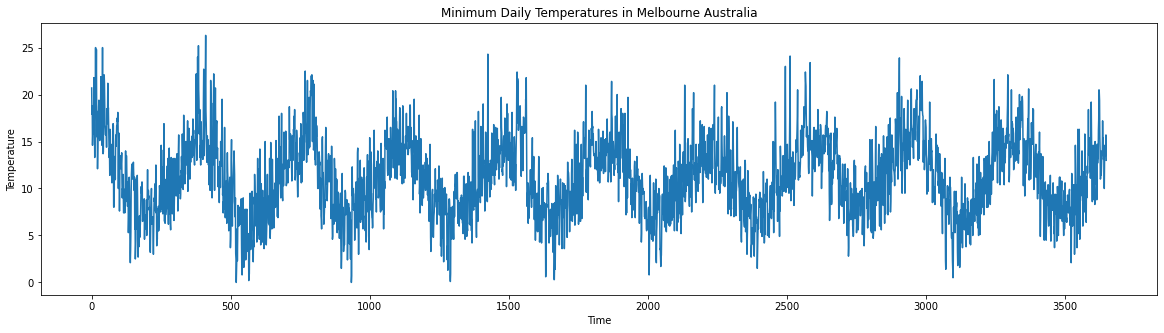

In [4]:
plt.figure(figsize = [20,5])
plt.plot(data.Temp)
plt.title("Minimum Daily Temperatures in Melbourne Australia")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.show()

In [5]:
train_percentage = 0.67
train_size = int(len(data)*train_percentage)

train = data["Temp"][:train_size].values.astype(float)
test = data["Temp"][train_size:].values.astype(float)

sc = MinMaxScaler(feature_range=(-1, 1))
train_norm = sc.fit_transform(train .reshape(-1, 1))

train_norm = torch.FloatTensor(train_norm).view(-1)

In [6]:
def create_input_output(input_data, window, ndays = 1):
    input_output = []
    data_size = len(input_data)
    for i in range(data_size - window - ndays):
        train_seq = input_data[i:i+window]
        train_label = input_data[i+window+ndays:i+window+ndays+1]
        input_output.append((train_seq ,train_label))
    return input_output
ndays = 5
window = 30
train_input_output = create_input_output(train_norm, window, ndays)
train_input_output[:2]

[(tensor([ 0.5741,  0.3612,  0.4297,  0.1103,  0.2015,  0.2015,  0.2015,  0.3232,
           0.6578,  0.5209,  0.2319,  0.0114,  0.2700,  0.6350,  0.9011,  0.5741,
           0.5665,  0.8859,  0.3460,  0.1787,  0.3840, -0.0798,  0.0951,  0.2167,
           0.2548,  0.4221,  0.4753,  0.3080,  0.1787,  0.1483]),
  tensor([0.2624])),
 (tensor([ 0.3612,  0.4297,  0.1103,  0.2015,  0.2015,  0.2015,  0.3232,  0.6578,
           0.5209,  0.2319,  0.0114,  0.2700,  0.6350,  0.9011,  0.5741,  0.5665,
           0.8859,  0.3460,  0.1787,  0.3840, -0.0798,  0.0951,  0.2167,  0.2548,
           0.4221,  0.4753,  0.3080,  0.1787,  0.1483,  0.1711]),
  tensor([0.2776]))]

In [7]:
len(train_input_output), len(train_input_output[0]), np.shape(train_input_output[0][0]), np.shape(train_input_output[0][1])

(2410, 2, torch.Size([30]), torch.Size([1]))

In [8]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq.view(len(input_seq) ,1, -1))
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [9]:
model = LSTM()
loss_function = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #torch.optim.SGD(model.parameters(), lr=0.001)

In [10]:
epochs = 10

for i in range(epochs):
    for inputs, labels in train_input_output:
        optimizer.zero_grad()

        y_pred = model(inputs)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%10 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.03554748
epoch:   9 loss: 0.0410433300


In [17]:
test_norm = sc.transform(test.reshape(-1, 1))
test_norm = torch.FloatTensor(test_norm).view(-1)
test_input_output = create_input_output(test_norm, window, ndays)
test_input_output[:2]

[(tensor([-0.4829, -0.2928, -0.2548, -0.1863, -0.4068, -0.3004,  0.1407, -0.4068,
          -0.5970, -0.2776, -0.4221,  0.0646,  0.1331,  0.1331,  0.4601,  0.2928,
          -0.0114, -0.1483, -0.2776, -0.2167, -0.2928, -0.1407, -0.5057, -0.0875,
          -0.3688, -0.3384, -0.3384, -0.2243, -0.4753, -0.6274]),
  tensor([-0.2319])),
 (tensor([-0.2928, -0.2548, -0.1863, -0.4068, -0.3004,  0.1407, -0.4068, -0.5970,
          -0.2776, -0.4221,  0.0646,  0.1331,  0.1331,  0.4601,  0.2928, -0.0114,
          -0.1483, -0.2776, -0.2167, -0.2928, -0.1407, -0.5057, -0.0875, -0.3688,
          -0.3384, -0.3384, -0.2243, -0.4753, -0.6274, -0.2395]),
  tensor([-0.1407]))]

In [18]:
y_pred_norm = []
for inputs, labels in test_input_output:
    with torch.no_grad():
        y_pred_norm.append(model(inputs).item())
y_pred_norm[:5]

[-0.41183459758758545,
 -0.3918399512767792,
 -0.4049898684024811,
 -0.3424821197986603,
 -0.3146244287490845]

In [19]:
y_pred = sc.inverse_transform(np.array(y_pred_norm).reshape(-1, 1))
y_pred[:5]

array([[7.73437504],
       [7.99730464],
       [7.82438323],
       [8.64636012],
       [9.01268876]])

In [20]:
y_true = test[window+ndays:]

In [21]:
mean_squared_error(y_true, y_pred) #daba 19 con una sola iteracion

9.618241658803518

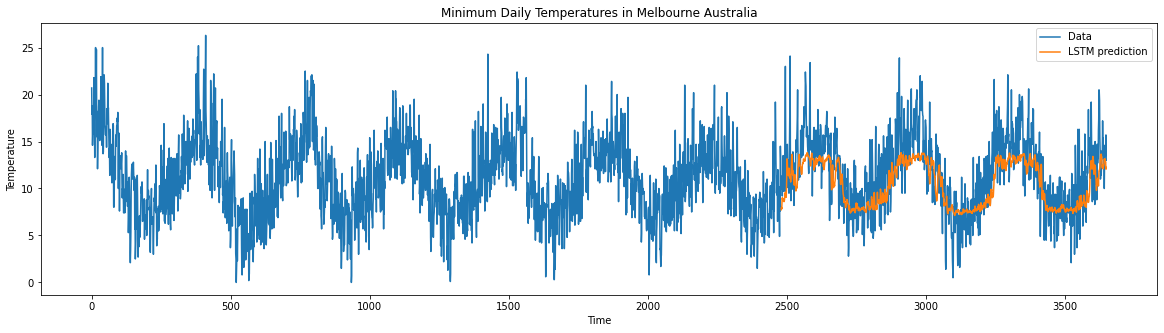

In [22]:
plt.figure(figsize = [20,5])
plt.plot(data.Temp, label="Data")
plt.plot(range(len(train)+window+ndays, len(train) + len(test)), y_pred, label="LSTM prediction")
plt.title("Minimum Daily Temperatures in Melbourne Australia")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.legend()
plt.show()